In [1]:
import pyedflib
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

trainPath = r"D:\v2.0.3\edf\train"
evalPath = r"D:\v2.0.3\edf\eval"
labelPath = r"C:\Users\dalto\Box Sync\abnLabels.csv"

labelFrame = pd.read_csv(labelPath)

labels = []
names = []
tests = []
noLabelCnt = 0

for split in enumerate([os.listdir(trainPath), os.listdir(evalPath)]):
    test = split[0]

    subName = split[1]

    for sub in subName:
        # if sub is in labelFrame
        if len(labelFrame.loc[labelFrame['name'] == sub]) == 0:
            print("No label found for", sub)
            noLabelCnt += 1
        else:
            labels.append(labelFrame.loc[labelFrame['name'] == sub, 'label'].values[0])
            names.append(sub)
            tests.append(test)

df = pd.DataFrame({'name': names, 'label': labels, 'test': tests})

display(df)

No label found for aaaaaagt
No label found for dataset-tuh_task-binary_datatype-train_v6
No label found for aaaaaqfm
No label found for aaaaaqmo
No label found for aaaaaqxr


,name,label,test
0,aaaaaaac,3,0
1,aaaaaaag,3,0
2,aaaaaaar,0,0
3,aaaaaaav,0,0
4,aaaaaabg,0,0
...,...,...,...
613,aaaaaswc,3,1
614,aaaaatao,0,1
615,aaaaatba,0,1
616,aaaaatdq,3,1


In [2]:
import glob

# list all of the .edf files in each train and eval folder
healthyEdfs = []  # List to store the paths of all .edf files
seizEdfs = []  # List to store the paths of all .edf files
edfLabels = []  # List to store the labels corresponding to each .edf file

# Sample of the 'df' DataFrame (in your case, the DataFrame might already be available)
# df = pd.read_csv('path/to/your_dataframe.csv')

# Loop through each subject in the 'names' list
for subject in names:
    subject_path = os.path.join(trainPath, subject)
    
    # Find the label corresponding to the subject from the DataFrame
    subject_label = df[df['name'] == subject]['label'].values[0]
    
    # Loop through all the date of recording folders (e.g., s001_2002)
    if os.path.exists(subject_path):
        for recording_date in os.listdir(subject_path):
            recording_date_path = os.path.join(subject_path, recording_date)
            
            # Loop through all cap setup folders (e.g., 02_tcp_le)
            if os.path.isdir(recording_date_path):
                for cap_setup in os.listdir(recording_date_path):
                    cap_setup_path = os.path.join(recording_date_path, cap_setup)
                    
                    # Find all .edf files in the final directory
                    if os.path.isdir(cap_setup_path):
                        edf_files_in_dir = glob.glob(os.path.join(cap_setup_path, "*.edf"))
                        
                        # Add each .edf file to the list, and also add its corresponding label
                        for edf_file in edf_files_in_dir:
                            if subject_label == 0:
                                healthyEdfs.append(edf_file)
                            else:
                                seizEdfs.append(edf_file)

# check for any duplicate .edf files
healthyEdfs = list(set(healthyEdfs))
seizEdfs = list(set(seizEdfs))
edfFiles = healthyEdfs + seizEdfs

# add the labels to the edf files
edfLabels = [0] * len(healthyEdfs) + [3] * len(seizEdfs)

# print the number of edf files
print("Edf count:", len(edfFiles))

# print the number of subjects in each edfLabel class
print("Healthy count:", len([x for x in edfLabels if x == 0]))
print("Seizure count:", len([x for x in edfLabels if x == 3]))


#### ONLY FOR EXPORTING TO CSV ####
# # take everything after 'train\' and add it to a new list
# edfNames = [x.split('train\\')[1] for x in edfFiles]

# # save the edfNames and edfLabels to a csv
# edfDf = pd.DataFrame({'name': edfNames, 'label': edfLabels})
# edfDf.to_csv('edfFiles.csv', index=False)

Edf count: 4662
Healthy count: 3489
Seizure count: 1173


In [3]:
# Set the desired number of channels and fixed length of time points
TARGET_CHANNELS = 40  # Number of channels you want to have in the final data
TARGET_POINTS = 75000  # Fixed number of time points for each sample

# Function to load and preprocess each .edf file
def load_and_preprocess_edf(filePath, target_channels=TARGET_CHANNELS, target_points=TARGET_POINTS):
    # Load the raw EEG data
    RawEEGDataFile = mne.io.read_raw_edf(filePath, preload=True, verbose=False)
    RawEEGDataFile.interpolate_bads()

    # Get the raw data (channels × time)
    data = RawEEGDataFile.get_data()

    # Determine current number of channels
    current_channels, current_points = data.shape

    # Pad or truncate channels to make them equal to target_channels (e.g., 40)
    if current_channels < target_channels:
        # Pad with zeros if there are fewer channels than target_channels
        padding = target_channels - current_channels
        data = np.pad(data, ((0, padding), (0, 0)), mode='constant')
    else:
        # Truncate channels if there are more than target_channels
        data = data[:target_channels, :]

    # Interpolate or resample data to ensure target_points are present
    if current_points != target_points:
        data = np.array([np.interp(np.linspace(0, current_points - 1, target_points), np.arange(current_points), data[ch, :]) for ch in range(target_channels)])

    return data

In [49]:
# merge the edfFiles and edfLabels into a dataframe and shuffle it
mlData = pd.DataFrame({'file': edfFiles, 'label': edfLabels})
mlData = mlData.sample(frac=1).reset_index(drop=True)

# cut the list down to 200 files while keeping the count of each label the same
mlData = mlData.groupby('label').head(250)

# set all '3' values in the label column to '1'
mlData['label'] = mlData['label'].replace(3, 1)

# mlData = mlData.head(200)
display(mlData)

# print the number of each label in the dataframe
print("Healthy count:", len(mlData[mlData['label'] == 0]))
print("Seizure count:", len(mlData[mlData['label'] == 1]))

print(len(mlData))

,file,label
0,D:\v2.0.3\edf\train\aaaaapwy\s007_2014\01_tcp_...,0
1,D:\v2.0.3\edf\train\aaaaanrp\s005_2013\01_tcp_...,0
2,D:\v2.0.3\edf\train\aaaaakfo\s004_2010\01_tcp_...,0
3,D:\v2.0.3\edf\train\aaaaaiea\s004_2009\03_tcp_...,0
4,D:\v2.0.3\edf\train\aaaaacle\s007_2010\03_tcp_...,0
...,...,...
869,D:\v2.0.3\edf\train\aaaaapmd\s004_2013\01_tcp_...,1
871,D:\v2.0.3\edf\train\aaaaamoe\s003_2012\01_tcp_...,1
877,D:\v2.0.3\edf\train\aaaaaasy\s003_2003\01_tcp_...,1
884,D:\v2.0.3\edf\train\aaaaaapo\s002_2003\02_tcp_...,1


Healthy count: 250
Seizure count: 250
500


In [ ]:
# Cell 1: Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import mne  # assuming mne is used for EEG data loading
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import gc

# Cell 2: Define a dataset class to load EEG data in segments
class EEGDataset(Dataset):
    def __init__(self, eeg_file_paths, target_channels=40, target_points=5000, segment_length=500, max_time_points=100000):
        self.eeg_file_paths = eeg_file_paths
        self.target_channels = target_channels
        self.target_points = target_points
        self.segment_length = segment_length
        self.max_time_points = max_time_points  # Limit the number of time points loaded

    def __len__(self):
        return len(self.eeg_file_paths)

    def __getitem__(self, idx):
        file_path = self.eeg_file_paths[idx]
        raw = mne.io.read_raw_edf(file_path, preload=True)

        # Apply preprocessing steps such as ICA or filtering here
        data = raw.get_data()  # Shape: (channels, time_points)

        # Limit the number of time points if they exceed max_time_points
        if data.shape[1] > self.max_time_points:
            data = data[:, :self.max_time_points]

        # Pad or trim channels to match target_channels
        if data.shape[0] < self.target_channels:
            # If the number of channels is less than target_channels, pad with zeros
            padding = np.zeros((self.target_channels - data.shape[0], data.shape[1]))
            data = np.vstack((data, padding))
        elif data.shape[0] > self.target_channels:
            # If the number of channels is more than target_channels, trim the channels
            data = data[:self.target_channels, :]

        # Randomly select a segment to keep the data size manageable
        if data.shape[1] > self.segment_length:
            start = np.random.randint(0, max(1, data.shape[1] - self.segment_length))
            end = start + self.segment_length
            segment = data[:, start:end]
        else:
            # If the data has fewer time points than segment_length, use all available points
            segment = data

        # Interpolate or compress each segment to match target_points
        if segment.shape[1] != self.target_points:
            segment = np.array([np.interp(np.linspace(0, 1, self.target_points),
                                          np.linspace(0, 1, segment.shape[1]), channel)
                                for channel in segment])

        # Reshape segment to match the input dimensions required by the model
        segment = np.expand_dims(segment, axis=0)  # Add a single channel dimension

        return torch.tensor(segment, dtype=torch.float32)


# Cell 3: List of all your EEG file paths
eeg_files = mlData['file'].tolist()

# Cell 4: Create a dataset and a dataloader for batch processing
batch_size = 2  # Set batch size based on your system's memory
dataset = EEGDataset(eeg_files, target_channels=40, target_points=5000, segment_length=500)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Cell 5: Define the CNN model
class CNN(nn.Module):
    def __init__(self, in_channels=1):
        super(CNN, self).__init__()
        # Define a simple CNN architecture
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer with kernel size 2 and stride 2

        # Define fully connected layers
        # Placeholder for input size to fc1; we'll calculate this dynamically
        self.fc1 = nn.Linear(32 * 40 * 625, 128)
        self.fc2 = nn.Linear(128, 2)  # Assuming binary classification

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Dynamically calculate the input size for fc1
def get_flattened_size(model, input_shape):
    dummy_input = torch.zeros(1, *input_shape)
    features = model.conv1(dummy_input)
    features = model.pool(features)
    features = model.conv2(features)
    features = model.pool(features)
    return features.numel()

# Create an instance of the CNN
input_channels = 1
model = CNN(in_channels=input_channels)

# Calculate the flattened size
flattened_size = get_flattened_size(model, (input_channels, 40, 5000))

# Update the model's fully connected layer to use the correct input size
model.fc1 = nn.Linear(flattened_size, 128)

# Cell 6: Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Cell 7: Training loop with batch processing
num_epochs = 2  # Set the number of epochs
all_labels = []
all_preds = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, batch in enumerate(dataloader):
        inputs = batch
        # Get labels from edfLabels and convert them to a torch tensor
        # labels = ml[i * batch_size : (i + 1) * batch_size]
        labels = mlData['label'].tolist()[i * batch_size : (i + 1) * batch_size]
        labels = torch.tensor(labels, dtype=torch.long)

        # Zero the gradient
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Store predictions and labels for evaluation
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

        # Clear unused variables to free memory
        del inputs, labels, outputs, loss
        gc.collect()
        torch.cuda.empty_cache()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader)}")

# Calculate evaluation metrics
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

conf_matrix = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
sensitivity = recall_score(y_true, y_pred, pos_label=1)  # True Positive Rate (Recall)
specificity = recall_score(y_true, y_pred, pos_label=0)  # True Negative Rate

print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall for Positive Class): {sensitivity:.4f}")
print(f"Specificity (Recall for Negative Class): {specificity:.4f}")

print("Finished Training")


Extracting EDF parameters from D:\v2.0.3\edf\train\aaaaabui\s002_2004\01_tcp_ar\aaaaabui_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 91999  =      0.000 ...   229.998 secs...
Extracting EDF parameters from D:\v2.0.3\edf\train\aaaaaqkb\s001_2013\01_tcp_ar\aaaaaqkb_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 376831  =      0.000 ...  1471.996 secs...
Extracting EDF parameters from D:\v2.0.3\edf\train\aaaaasjq\s004_2014\03_tcp_ar_a\aaaaasjq_s004_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 160767  =      0.000 ...   627.996 secs...
Extracting EDF parameters from D:\v2.0.3\edf\train\aaaaanrb\s004_2012\01_tcp_ar\aaaaanrb_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150249  =      0.000 ...   600.996 secs...
Extracting EDF 

In [ ]:
# Calculate evaluation metrics
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

conf_matrix = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
sensitivity = recall_score(y_true, y_pred, pos_label=1)  # True Positive Rate (Recall)
specificity = recall_score(y_true, y_pred, pos_label=0)  # True Negative Rate

print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall for Positive Class): {sensitivity:.4f}")
print(f"Specificity (Recall for Negative Class): {specificity:.4f}")

print("Finished Training")

Confusion Matrix:
[[124  76]
 [ 93 107]]
Accuracy: 0.5775
Sensitivity (Recall for Positive Class): 0.5350
Specificity (Recall for Negative Class): 0.6200
Finished Training


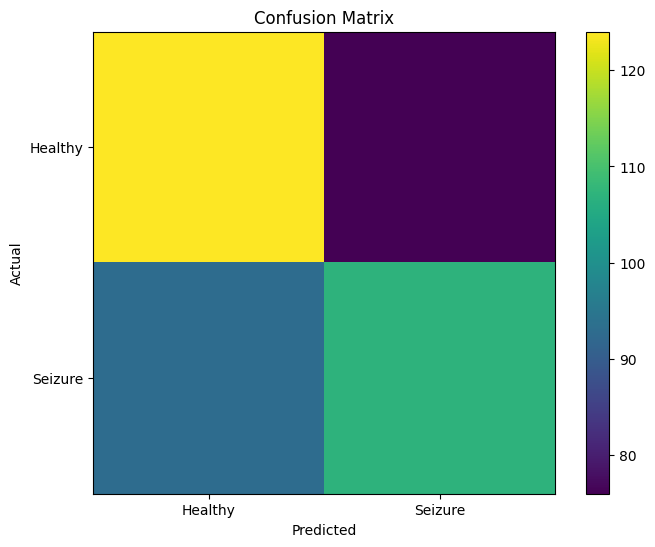

In [ ]:
# plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0, 1], ['Healthy', 'Seizure'])
plt.yticks([0, 1], ['Healthy', 'Seizure'])

# show the values in the heatmap
for i in range(2):
    for j in range(2):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='black')

plt.show()